#  Detex Tutorial

Detex is a python package for performing waveform similarity clustering and subspace detection. It is written in python and relies heavily on Obspy, Numpy, Scipy, Matplotlib, and Pandas. If you are not familiar with python I recommend you install the [anaconda distribution](http://continuum.io/downloads) for your platform and spend a few hours learning the basics of the language before attempting to use Detex. Here are some great tutorials:

http://www.stavros.io/tutorials/python/
http://www.tutorialspoint.com/python/python_quick_guide.htm

Also, any time spent learning [obspy](http://docs.obspy.org/tutorial/) is a great investment as it is a very powerful tool for geophysical processing.

Some knowledge of pandas will also be useful, as the pandas DataFrame is used extensively in detex. [Here](http://pandas.pydata.org/pandas-docs/stable/10min.html) is a 10 minute tutorial that will give you the basics.

Special thanks to Tex Kubacki (whose work inspired Detex), Jared Stein, and all the students and faculty at the University of Utah that helped test detex. 

## Installation 

Detex can be installed by running the setup.py script in the distribution directory.

## Workflow

The basic Detex workflow has five steps:

1. Prepare required files
2. Data acquisition
3. Clustering
4. Subspace detection
5. Detection association



##  1. Prepare required files
There are two required files: the station key and the template key.

The station key is generally saved as StationKey.csv. The following is an example:


| NEWTORK | STATION | STARTTIME | ENDTIME | LAT | LON | ELEVATION | CHANNELS |
|:-------:|--------:|:---------:| :-----: | :-: | :-: | :-------: | :------: |
| TA | M18A	| 2009-04-01T00:00:00 | 2009-04-04T00:00:00	| 41.4272 | -110.0674 | 2103 | BHE-BHN-BHZ |
| TA | M17A	| 2009-04-01T00:00:00 | 2009-04-04T00:00:00	| 41.4729 | - 110.6664 | 2101 | BHE-BHN-BHZ |

The STARTTIME and ENDTIME fields indicated the time range of the continuous data and can be in any format readable by the obspy.UTCDateTime class (including a time stamp). See the obspy.UTCDateTime docs for more info (http://docs.obspy.org/packages/autogen/obspy.core.utcdatetime.UTCDateTime.html)

The CHANNELS field should list the channels that will be used for each station separated by a dash (-). Additionally, any extra fields can be added without affecting Detex's ability to read the file.

The template key by default is saved as TemplateKey.csv. It contains information on each of the events that will be used to scan the continuous data for previously undetected events. Here is a few lines of the template key included in this tutorial:

| CONTRIBUTOR | NAME | TIME | LAT | LON | DEPTH | MTYPE | MAG |
| :--: | :--: | :--: | :--: | :--: |:--: | :--: |:--: |
| ANF | 2007-12-19T17-56-18 | 2007-12-19T17-56-18 | 41.7205	| -110.6486	| 4.07 | ML | 2.36 |
| ANF | 2007-12-21T18-30-09	| 2007-12-21T18-30-09 | 41.7669	| -110.6122	| 8.97 | ML | 2.17 |
| ANF | 2007-12-21T18-30-09	| 2007-12-21T18-30-09 | 41.7669	| -110.6122	| 8.97 | ML	| 2.17 |

The CONTRIBUTOR, MTYPE, and DEPTH fields are not required but can be useful for record keeping. Additionally, any extra fields can be added in any order in order to better keep track of the events. 

The NAME field can be any string that can also be used as a file name by your OS. Windows does not allow ":" in a file path so the ":" between the hour and minute, and between the minute and seconds, have been replaced with a "-". Again, the time field can be in any format understood by obspy.UTCDateTime.

The LAT and LON fields are not strictly required for basic Detex functionality, but are used in some visualization methods. 


##  2. Data aquisition
Detex can use a variety of data sources. In the intro tutorial we will use obspy's [fdsn module](https://docs.obspy.org/packages/autogen/obspy.station.inventory.Inventory.html) to download seismic data from IRIS and store it in a local directory structure for quick access. 


In [1]:
import detex #import detex module
# the next line is only needed in ipython notebook to make sure all figures show inline 
%pylab inline 
detex.getdata.makeDataDirectories() #download all data from iris

/home/derrick/anaconda2/lib/python2.7/site-packages/obspy/__init__.py:157: ObsPyDeprecationWarning: Module 'obspy.fdsn' is deprecated and will stop working with the next ObsPy version. Please import module 'obspy.clients.fdsn' instead.
  ObsPyDeprecationWarning)
/home/derrick/anaconda2/lib/python2.7/site-packages/obspy/__init__.py:157: ObsPyDeprecationWarning: Module 'obspy.neic' is deprecated and will stop working with the next ObsPy version. Please import module 'obspy.clients.neic' instead.
  ObsPyDeprecationWarning)
/home/derrick/anaconda2/lib/python2.7/site-packages/obspy/__init__.py:157: ObsPyDeprecationWarning: Module 'obspy.earthworm' is deprecated and will stop working with the next ObsPy version. Please import module 'obspy.clients.earthworm' instead.
  ObsPyDeprecationWarning)
/home/derrick/anaconda2/lib/python2.7/site-packages/obspy/core/util/deprecation_helpers.py:57: ObsPyDeprecationWarning: Function 'obspy.signal.trigger.classicSTALTA' is deprecated and will stop working

Populating the interactive namespace from numpy and matplotlib
Getting template waveforms
Getting continuous data
finished makeDataDirectories call


/home/derrick/anaconda2/lib/python2.7/site-packages/obspy/core/util/deprecation_helpers.py:67: ObsPyDeprecationWarning: Module 'obspy.station' is deprecated and will stop working with the next ObsPy version. Please import module 'obspy.core.inventory'instead.
  warnings.warn(msg, ObsPyDeprecationWarning)


##  3. Clustering
The next step is to cross correlate every event with every other event in order to form waveform similarity groupings on each station. A single link-algorithm is used to perform the clustering up to a determined dissimilarity level.   

In order to do this a clusterStream object is created, which is essentially a container for groupings on each station. The main input parameter is the required correlation coefficient, below which clustering will not occur. If you want to run each waveform as a 1D subspace (IE in waveform correlation detection) you can simply set the required correlation coefficient to 1. Conversely, if you want to include all events in the subspace regardless of similarity then set this parameter to 0. The default value is 0.5 can be easily changed without re-running the correlations. For example:

In [2]:
cl = detex.createCluster() # Create a clusters stream object

Cannot remove response without a valid inventoryArg, setting removeResponse to False
Starting IO operations and data checks
performing cluster analysis on TA.M17A
performing cluster analysis on TA.M18A
ccReq for station TA.M17A updated to ccReq=0.500
ccReq for station TA.M18A updated to ccReq=0.500
writing ClusterStream instance as clust.pkl


/home/derrick/anaconda2/lib/python2.7/site-packages/detex/getdata.py:784: ObsPyDeprecationWarning: 
        DEPRECATED: 'formatIRISWebService' has been renamed to
        'format_iris_web_service'. Use that instead.
        
  time = st[0].stats.starttime.formatIRISWebService().split('.')[0]


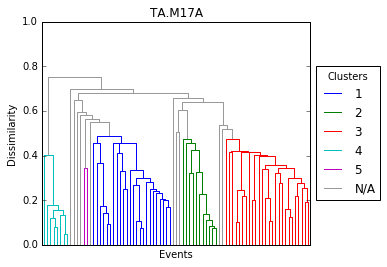

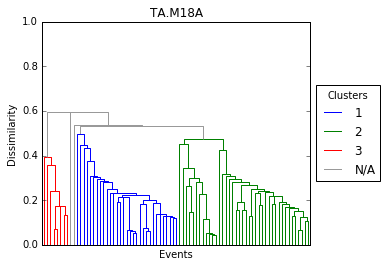

In [3]:
cl.dendro() #create a dendrogram to visualize grouping structure on each station

Now if we wanted to form strictly 4 groups on each station we can modify the required correlation coefficient for grouping. This can be done for all stations at once or for each station individually. 

ccReq for station TA.M17A updated to ccReq=0.550
ccReq for station TA.M18A updated to ccReq=0.550


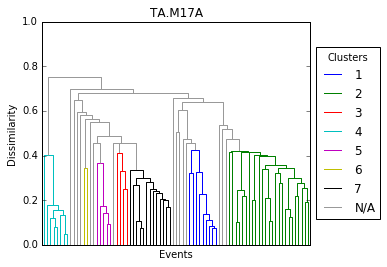

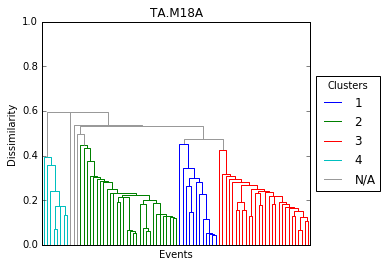

In [4]:
cl.updateReqCC(.55)
cl.dendro()

ccReq for station TA.M17A updated to ccReq=0.380


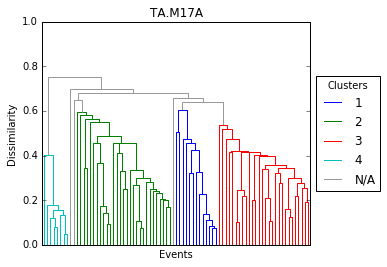

In [5]:
cl['TA.M17A'].updateReqCC(.38) # set required correlation coef. for only station TA.M17A
cl['TA.M17A'].dendro() # visualize grouping

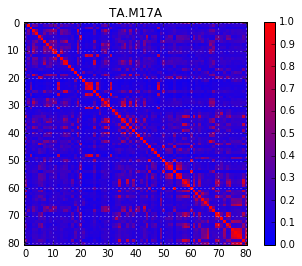

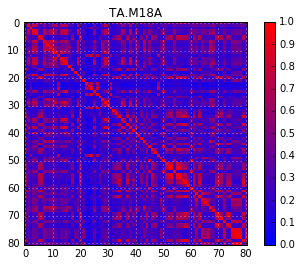

In [6]:
# Similarity matricies can also be generated
cl.simMatrix()

In [7]:
cl.write() # save cluster object to disk

writing ClusterStream instance as clust.pkl


There are several other functions of the ClusterStream class. Notably, input for hypoDD (a well-established double difference relocation program) can be created using the writeHypoDDEventInput, writeHypoDDStationInput, and writeSimpleHypoDDInput class methods; although as of version 0.1.0 they have not been fully tested. I hope to develop other methods for locating detected events in the future. 

## 4. Subspace detection
The subspace creation process is applied to each waveform similarity group. The process involves 1) aligning the waveforms to optimize similarity, 2) performing a singular value decomposition, 3) determining a required dimension of representation, and 4) setting a significant detection statistic threshold. As a final step 5) the subspace detectors are run on each station and saved to an SQLite database.

In [8]:
# First, the creation of the SubSpaceStream
ss = detex.createSubSpace() 

Cannot remove response without a valid inventoryArg, setting removeResponse to False
Starting Subspace Construction
Finished CreateSubSpace call


### 4.1 Trim waveforms
The next step is to set the beginning trim time for each subspace group and un-clustered singleton on each station. This can be done by calling GUI based pick functions built into the SubSpaceStream class (here it would be ss.detex.pickTimes()),or by attaching a csv or pickled pandas data frame with the following populated fields populated for at least one phase of each event-station pair:
TimeStamp, Station, Event, Phase. 

The EventPicks.pkl file included in the tutorial is such a file (you can create this file by calling detex.util.pickPhases or load the dataframe by calling pandas.read_csv). 

Detex will then find the first arriving phase for each waveform (event-station pair) and average for the entire aligned group. From the average first arrival sample the waveforms will be trimmed to some duration ( 30 seconds default) or to the last arriving phase. See the function docs for further details.


In [9]:
ss.attachPickTimes()

### 4.2, 4.3, 4.4 Perform SVD, set dimension of representation, and set threshold
Next a singular value decomposition is performed on the  waveform groups that have been aligned and trimmed. A dimension of representation (IE the number of left singular vectors used to describe the waveform family) is calculated based on the fractional energy capture of 90% (by default). A detection statistic (DS) threshold for each subspace and singleton is then determined by calculated the detection statistic of the subspace with random continuous data that contains no high amplitude signals, fitting a beta PDF to the distribution, and finding the DS corresponding to the selected probability of false detection $10^{-12}$ by default). 

In [10]:
ss.SVD()

###4.5 Run detectors
Detex will scan the continuous data for each station-subspace pair and declare a detection whenever any subspace's threshold is exceeded. 

In [11]:
ss.detex(useSingles=True) # run subspace detections and also run unclustered events as 1D subspaces 

Subspaces on TA.M17A completed, 8 potential detection(s) recorded
Subspaces on TA.M18A completed, 40 potential detection(s) recorded
Singletons on TA.M17A completed, 6 potential detection(s) recorded
Singletons on TA.M18A completed, 5 potential detection(s) recorded


The results are saved to an sqlite database. The following tables are saved in the database (named SubSpace.db by default):

| Table | Description |
|:-----:| :---------: |
| ss_df | Results of the detections for the subspaces |
| sg_df | Detection results for the singletons (un-clustered events) |
| filt_params | Filter parameters used for the detections |
| ss_info | General information about each of the subspaces (such as station, comprising events, thresholds, etc.) |
| sg_info | General information about each singleton |
| ss_hist | Binned counts of all detection statistic values for subspaces |
| sg_hist | Binned counts of all detection statistic values for singletons |

Any of these tables can be loaded into a dataframe using the detex.util.loadSQLite function. For example, if we wanted to make an ugly plot of all of the detection statistic values for the subspaces:

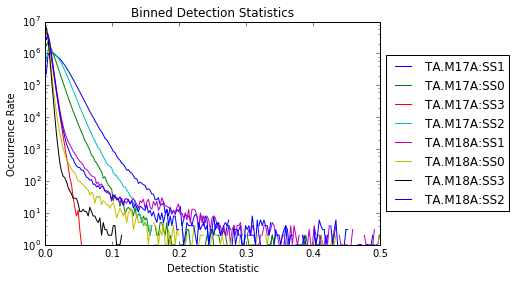

In [12]:
import matplotlib.pyplot as plt #import matplotlib for visualization
import json # used to convert string arrays as loaded from sql to numpy arrays

# load the ss_hist table of the SubSpace.db sqlite database
hist = detex.util.loadSQLite('SubSpace.db','ss_hist') 

for ind,row in hist.iterrows(): #loop over datarame
    #convert string arrays into numpy arrays 
    hist.loc[ind,'Value']=np.array(json.loads(row.Value)) 

# middle of bin values for histograms
avbins=(hist.iloc[0].Value[:-1]+hist.iloc[0].Value[1:])/2.0 

## Plot each histogram
for ind, row in hist.iterrows(): # loop again through dataframe
    if ind==0: # skip if index of dataframe is 0 (these are the bin values)
        continue 
    plt.plot(avbins, row.Value, label=row.Sta + ':' + row.Name) #plot
plt.xlabel('Detection Statistic') #label x
plt.ylabel('Occurrence Rate') # label y
plt.title('Binned Detection Statistics') # lable title
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #add legend
plt.semilogy() #use semilog on y axis
plt.xlim([0,.5]) #set x lim

plt.show() #show plot
    

## 5 Associate detections

The detex module "results" is used to associate all of the detections (DS that exceeded the determined threshold) on various stations together into coherent events. The association requirement is an overlap in predicted origin times. If a verification data set (IE event ground-truth) is available it can be used to assess detector performance. 

Note: If possible, it is very important to use at least 2 stations separated in space in order to reduce false detections.


In [13]:
# associate events together, only require events to occur on 2 stations (that's all we have), count detections verified if they
# occure within 10 minutes (5 minutes on either side) of reported origin times in blasting catalog. 
reload(detex.results)
res = detex.results.detResults(requiredNumStations=2,veriBuffer=60*10,veriFile='veriFile.csv') 

Cannot remove response without a valid inventoryArg, setting removeResponse to False


/home/derrick/anaconda2/lib/python2.7/site-packages/detex/results.py:447: ObsPyDeprecationWarning: 
        DEPRECATED: 'formatIRISWebService' has been renamed to
        'format_iris_web_service'. Use that instead.
        
  event = utc.formatIRISWebService().replace(':', '-').split('.')[0]


The associations may take a while for large data sets, there are still some optimizations that need to be implemented.
The verified detections, new detections, and auto detections (detection of training events) are stored in the form of pandas DataFrames that can be accessed by the Vers, Dets, and Autos attributes of the DetResults object. For example:


In [14]:
res.Dets

,Event,DSav,DSmax,NumStations,DS_STALTA,MSTAMPmin,MSTAMPmax,Mag,ProEnMag,Verified,Dets
0,2009-04-01T20-25-45,0.736188,0.809344,2,3.336267,1.238618e+09,1.238618e+09,2.265770,2.212966,True,DS DS_STALTA STMP Name ...
1,2009-04-02T16-27-05,0.840804,0.852189,2,3.644040,1.238690e+09,1.238690e+09,2.244815,2.220743,True,DS DS_STALTA STMP Name ...
2,2009-04-02T19-16-52,0.540468,0.640583,2,4.668685,1.238700e+09,1.238700e+09,2.059335,1.938139,True,DS DS_STALTA STMP Name ...
3,2009-04-03T17-34-28,0.522636,0.557576,2,4.883354,1.238780e+09,1.238780e+09,1.892123,1.771109,True,DS DS_STALTA STMP Name ...


In [15]:
res.Autos

,Event,DSav,DSmax,NumStations,DS_STALTA,MSTAMPmin,MSTAMPmax,Mag,ProEnMag,Verified,Dets
0,2009-04-01T17-36-58,0.998800,0.998964,2,8.644355,1.238607e+09,1.238607e+09,2.508141,2.523295,True,DS DS_STALTA STMP Name ...
1,2009-04-03T15-39-27,0.938718,0.943983,2,4.204317,1.238773e+09,1.238773e+09,2.319292,2.319515,True,DS DS_STALTA STMP Name ...


In [16]:
res.Vers

,Event,DSav,DSmax,NumStations,DS_STALTA,MSTAMPmin,MSTAMPmax,Mag,ProEnMag,Dets,STMP,MWD,VerMag,VerLat,VerLon,VerDepth,VerName
0,2009-04-01T17-36-58,0.998800,0.998964,2,8.644355,1.238607e+09,1.238607e+09,2.508141,2.523295,DS DS_STALTA STMP Name ...,1238607300,2943,2,n/a,n/a,0,9107
1,2009-04-01T20-25-45,0.736188,0.809344,2,3.336267,1.238618e+09,1.238618e+09,2.265770,2.212966,DS DS_STALTA STMP Name ...,1238617320,1713,2,n/a,n/a,0,9108
2,2009-04-02T16-27-05,0.840804,0.852189,2,3.644040,1.238690e+09,1.238690e+09,2.244815,2.220743,DS DS_STALTA STMP Name ...,1238689440,1542,2,n/a,n/a,0,9109
3,2009-04-02T19-16-52,0.540468,0.640583,2,4.668685,1.238700e+09,1.238700e+09,2.059335,1.938139,DS DS_STALTA STMP Name ...,1238700000,812,2,n/a,n/a,0,9110
4,2009-04-03T15-39-27,0.938718,0.943983,2,4.204317,1.238773e+09,1.238773e+09,2.319292,2.319515,DS DS_STALTA STMP Name ...,1238772960,2233,2,n/a,n/a,0,9111
5,2009-04-03T17-34-28,0.522636,0.557576,2,4.883354,1.238780e+09,1.238780e+09,1.892123,1.771109,DS DS_STALTA STMP Name ...,1238779800,1022,2,n/a,n/a,0,9112


Loading the mine's blast log we can see that all six blasts over the four days were successfully detected with no false detections. Note: the magnitude, latitude, longitude, and depth were not known so I simply use dummy values here.

In [17]:
import pandas as pd
log = pd.read_csv('veriFile.csv')
log

,NAME,TIME,MAG,LAT,LON,DEPTH,MWD
0,9107,2009-04-01T17-35-00,2,n/a,n/a,0,2943
1,9108,2009-04-01T20-22-00,2,n/a,n/a,0,1713
2,9109,2009-04-02T16-24-00,2,n/a,n/a,0,1542
3,9110,2009-04-02T19-20-00,2,n/a,n/a,0,812
4,9111,2009-04-03T15-36-00,2,n/a,n/a,0,2233
5,9112,2009-04-03T17-30-00,2,n/a,n/a,0,1022


If we only required the detections to occur on one station, however, (even with the default ultra-conservative acceptable probability of false detection of $10^{-12}$ the detector will return many false detections. For this reason it is important to use more than one station when possible.

In [18]:
import detex
res2 = detex.results.detResults(requiredNumStations=1,veriBuffer=60*10,veriFile='veriFile.csv')
res2

Cannot remove response without a valid inventoryArg, setting removeResponse to False


SSResults instance with 2 autodections and 18 new detections, 6 are verified

Once we have detected new events we can instruct detex to extract the waveforms of the new detections. With the extracted waveforms phase picks can be made in order to located the newly-found events, cross correlation lag times can be calculated with the clustering and the detected events can be used to create a new detector to potentially find more events.

In [19]:
res.writeDetections(eventDir='DetectedEvents',updateTemKey=False)

/home/derrick/anaconda2/lib/python2.7/site-packages/detex/results.py:623: ObsPyDeprecationWarning: 
        DEPRECATED: 'formatIRISWebService' has been renamed to
        'format_iris_web_service'. Use that instead.
        
  Evename = origin.formatIRISWebService().replace(':', '-')


Now the waveforms of the newly detected events have been stored with the same file structure as the TemplateWaveForms directory in a directory named DetectedEvents (because this is the argument we assigned to it). A new template key of the detected events can also be created, or by default the current template key csv will be updated with the newly detected events, unless we set updateTemKey to False. The naming convention is the same but detected events will have a lowercase "d," for detected, at the start of the name string. The entire process can then be repeated to try and detect more events, but in this case we know we have found all that there is to find. 

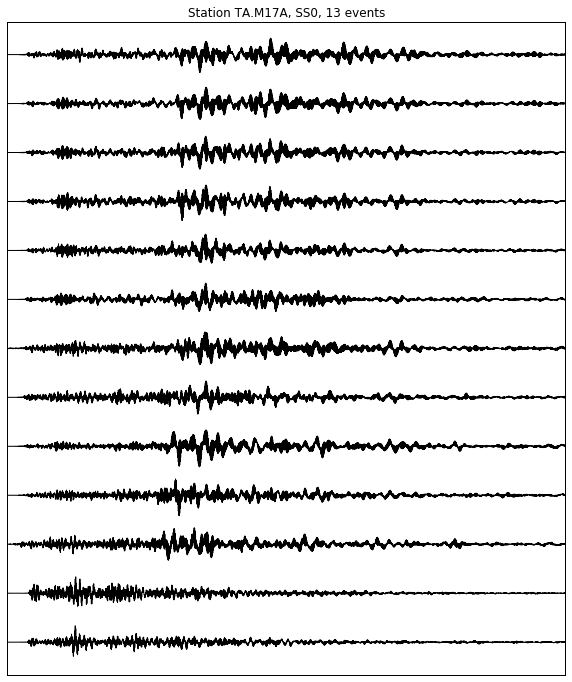

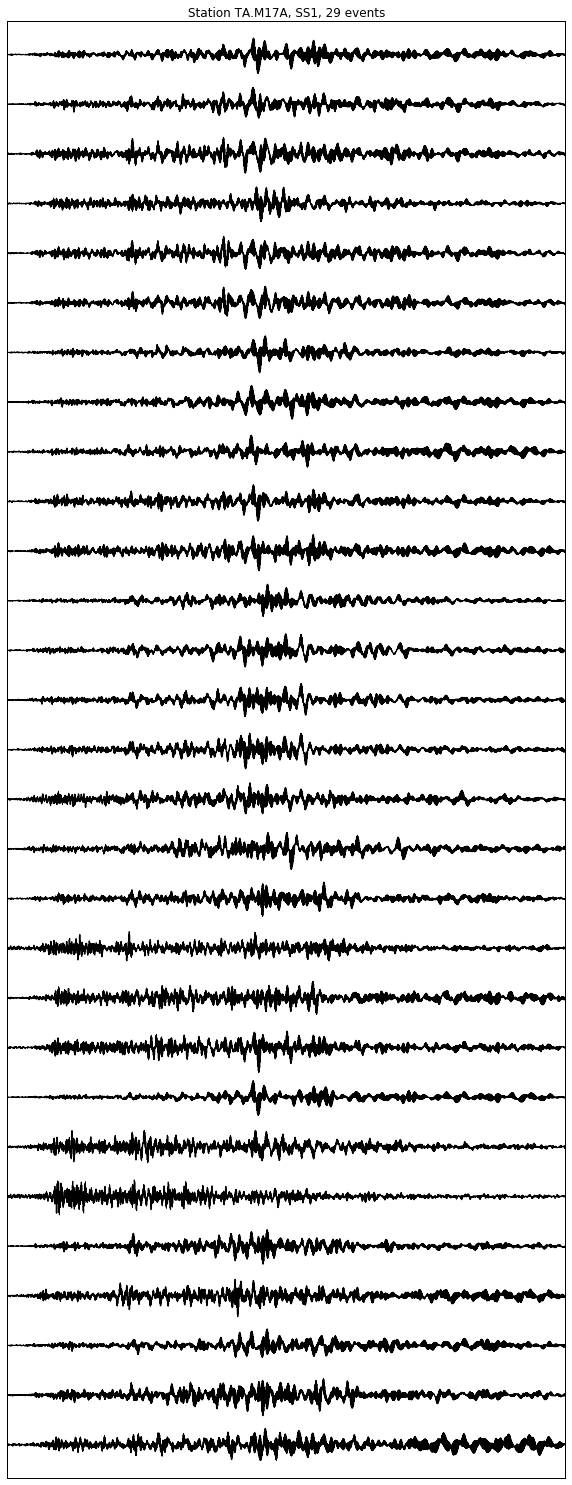

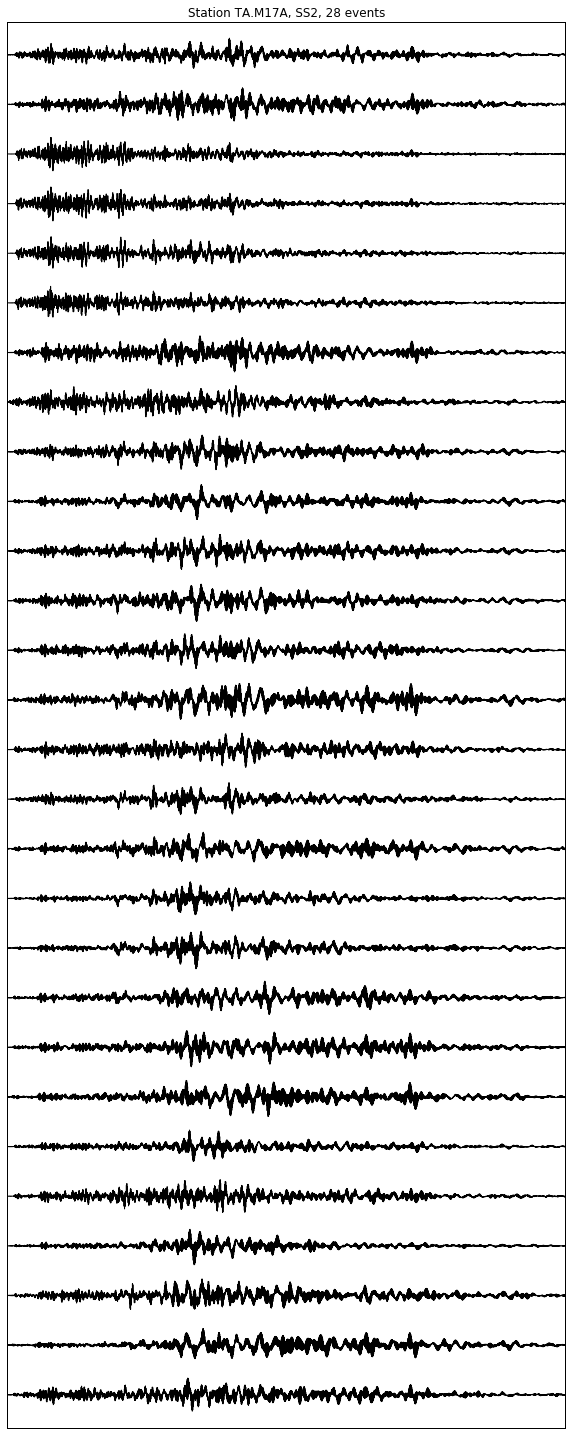

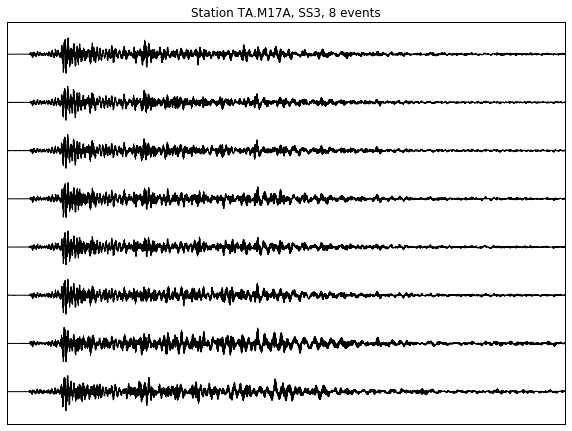

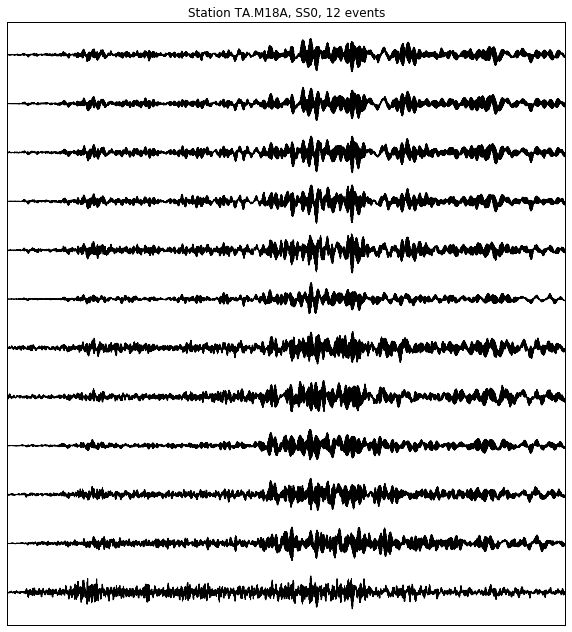

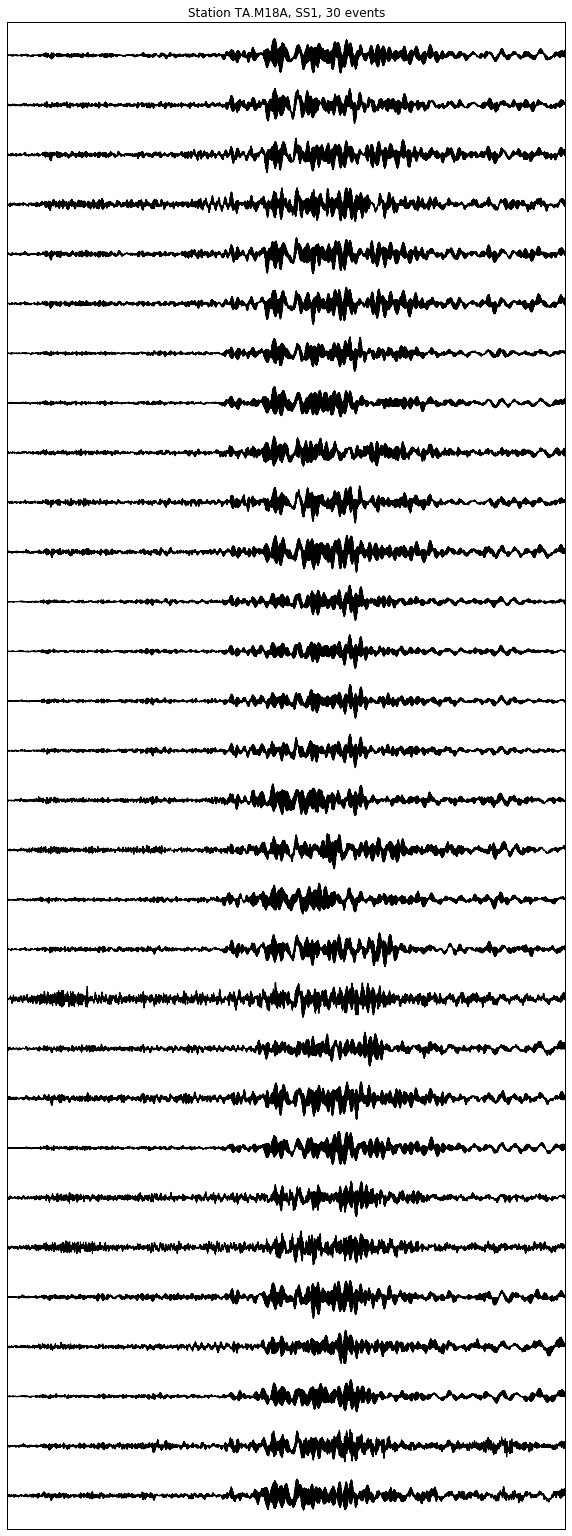

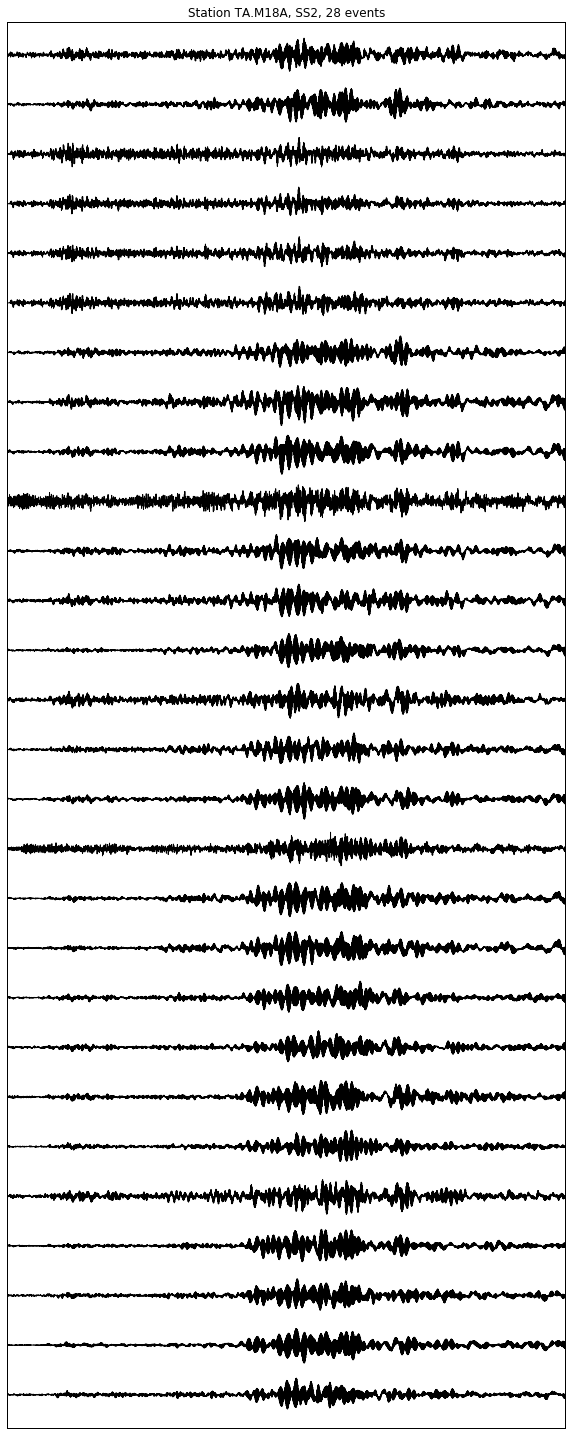

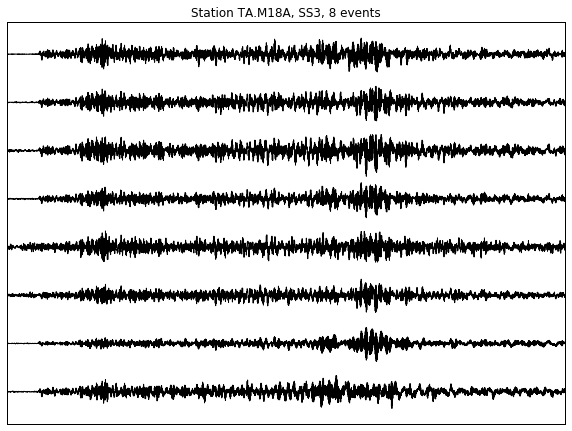

In [20]:
ss.plotAlignedEvents()

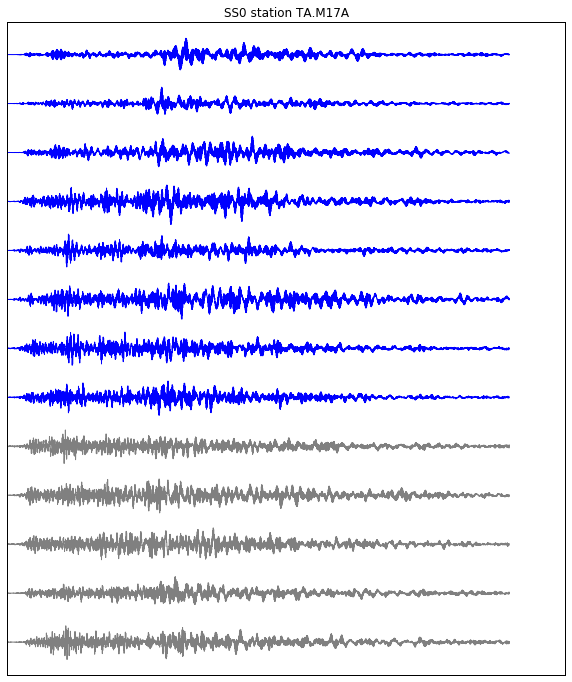

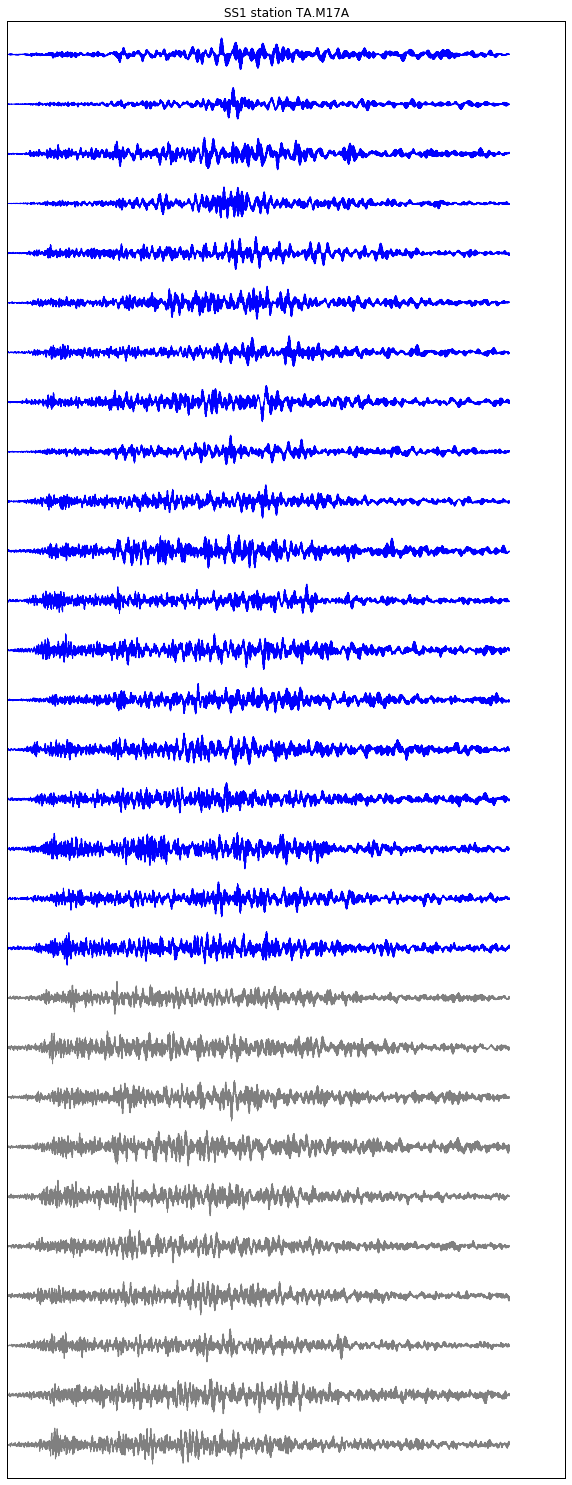

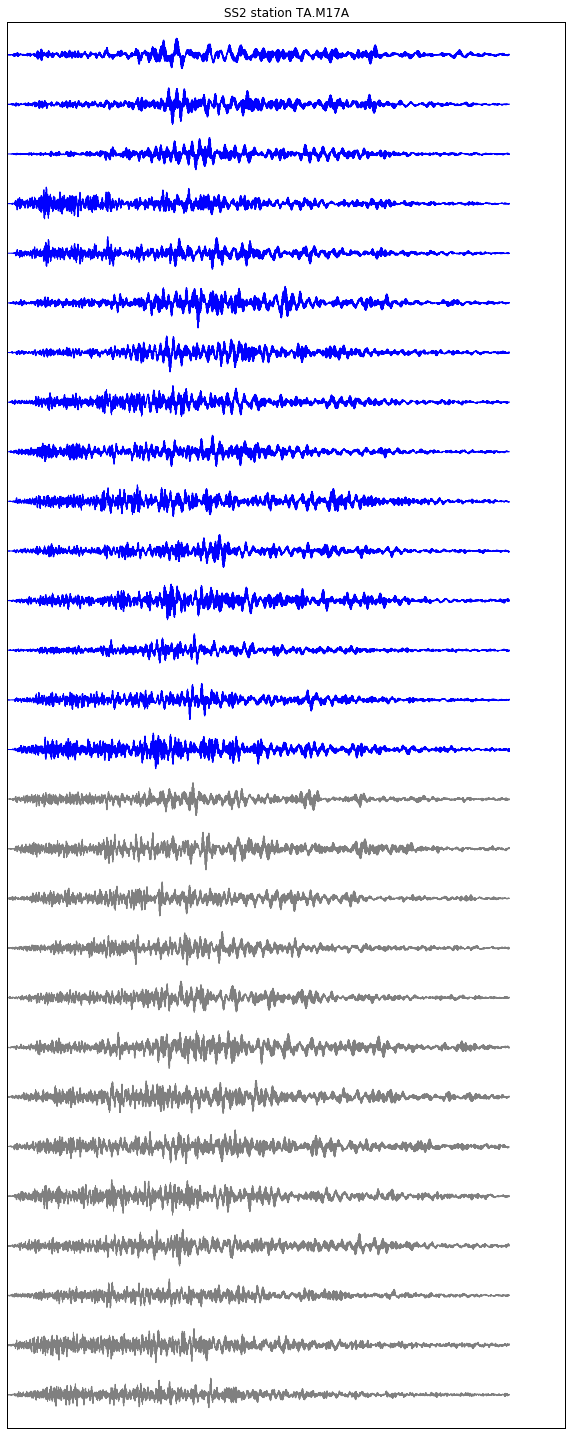

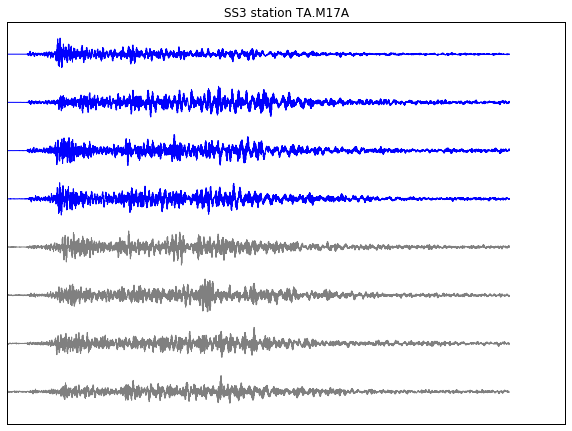

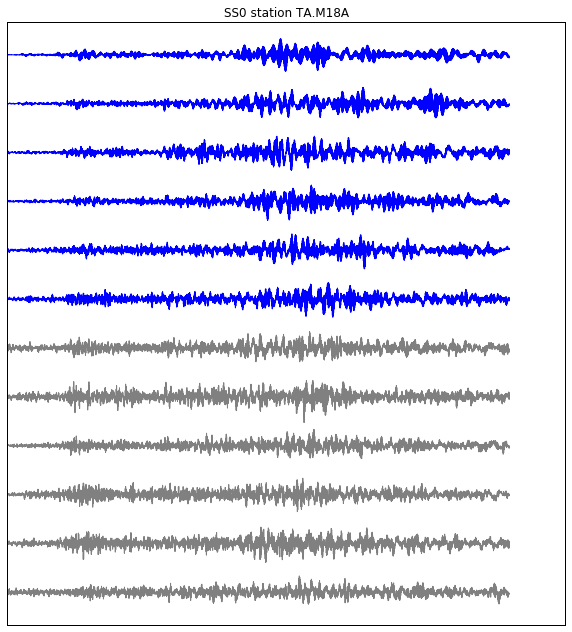

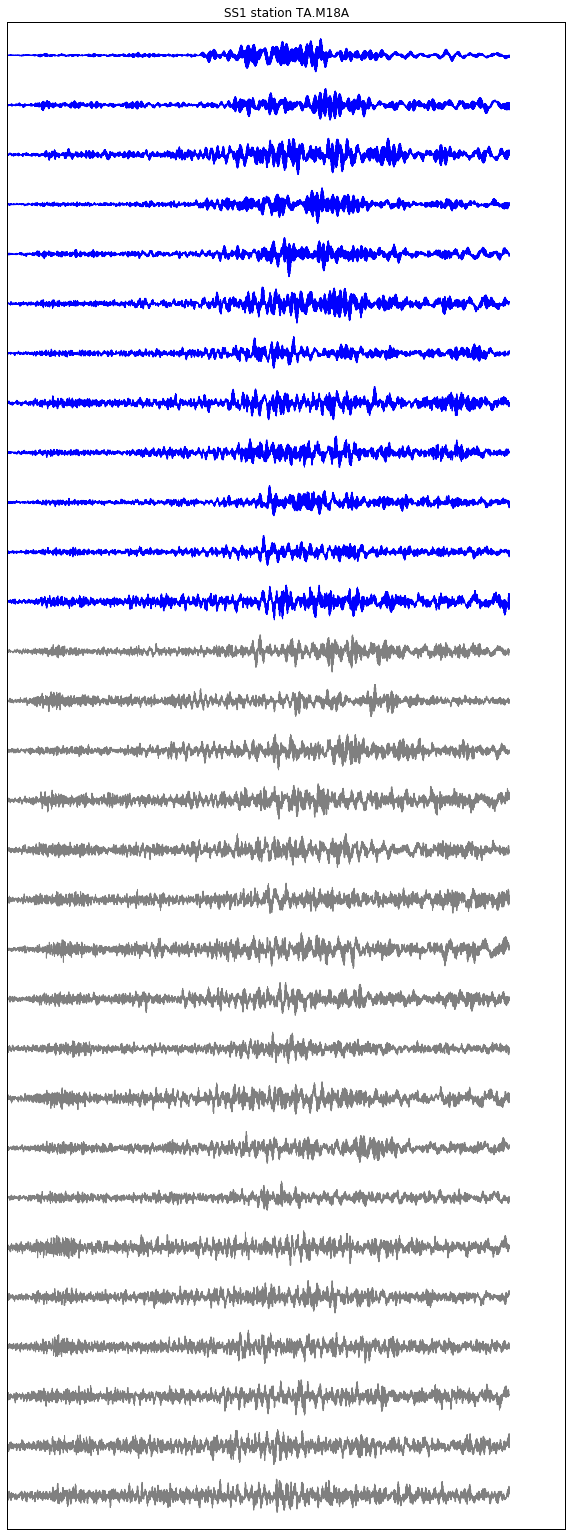

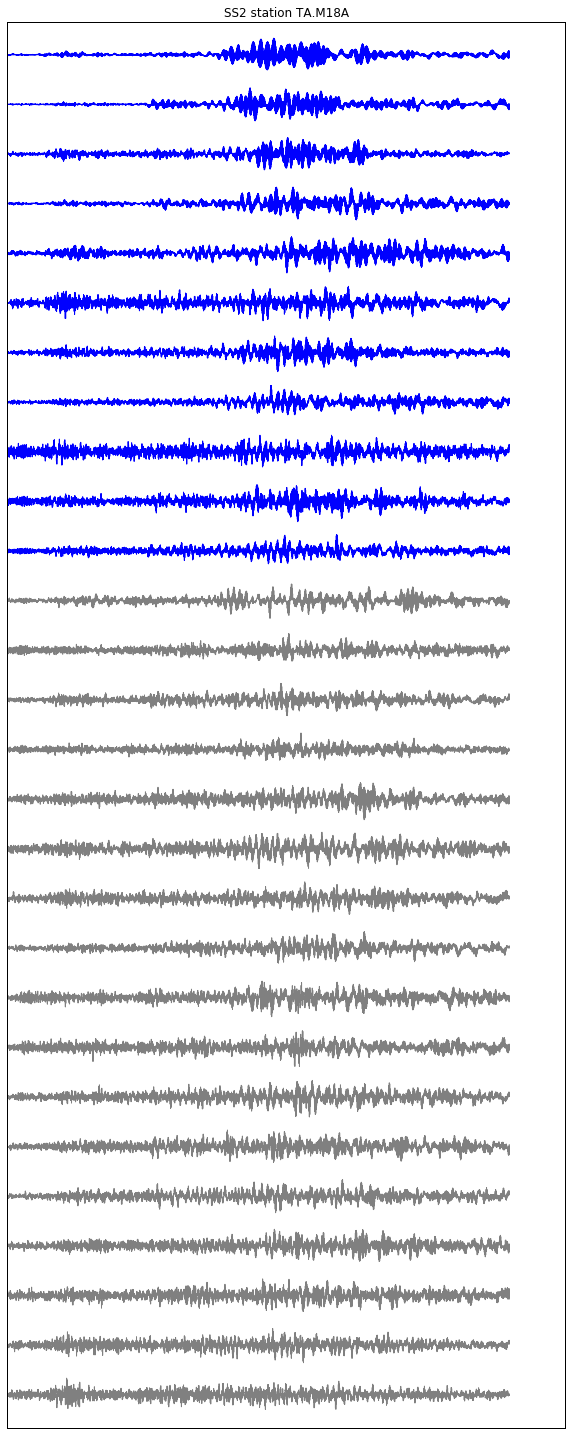

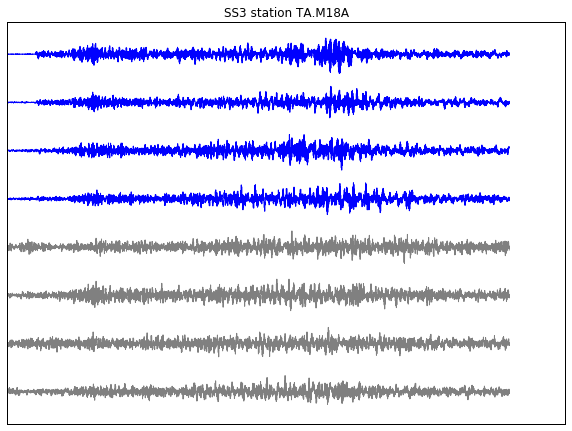

In [21]:
ss.plotBasisVectors()